# Fáza 2 - predspracovanie údajov
## Autori: Matej Delinčák (50%), Martin Pirkovský (50%)

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from numpy import mean
import datetime
from scipy import stats
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import OrdinalEncoder
from sklearn.pipeline import make_pipeline

from sklearn.base import TransformerMixin


pd.set_option("display.max_columns", None)

## 1. Integrácia a čistenie dát (5b)

In [15]:
def load_datasets(filename1, filename2):
    df_profiles = pd.read_csv(filename1, sep='\t', parse_dates=['birthdate'])
    df_profiles.drop('Unnamed: 0', axis=1, inplace=True)
    df_labor = pd.read_csv(filename2, sep='\t')
    df_labor.drop('Unnamed: 0', axis=1, inplace=True)
    return pd.merge(df_profiles,df_labor,on='name',how='outer')

In [16]:
df = load_datasets("001/profiles.csv","001/labor.csv")
df.head()

,sex,blood_group,job,residence,birthdate,ssn_x,current_location,race,name,erytrocyty,trombocyty,weight,hbver,ssn_y,relationship,er-cv,smoker,indicator,hematokrit,leukocyty,alp,hemoglobin,ast,alt,etytr
0,M,B-,Legal executive,"528 Allen Streets\nSolomonberg, NM 26158",1941-05-28,359-18-7254,"(Decimal('29.4768335'), Decimal('-42.485892'))",White,John Fletcher,5.73089,7.81439,74.67459,6.48334,359-18-7254,divoced,54.28887,N,1.0,6.68658,8.13103,71.53264,5.51496,72.78350,1.40153,8.26858
1,M,B-,Legal executive,"528 Allen Streets\nSolomonberg, NM 26158",1941-05-28,359-18-7254,"(Decimal('29.4768335'), Decimal('-42.485892'))",White,John Fletcher,7.00210,7.30681,64.56094,5.50101,359-18-7254,divoced,47.56065,no,1.0,8.14919,7.95707,53.26854,7.70607,70.42034,1.08658,8.76562
2,M,B-,Legal executive,"528 Allen Streets\nSolomonberg, NM 26158",1941-05-28,359-18-7254,"(Decimal('29.4768335'), Decimal('-42.485892'))",White,John Fletcher,5.87203,6.49993,102.55936,6.26296,359-18-7254,single,53.69510,yes,1.0,8.61871,8.80296,71.23821,5.67911,63.46493,0.94280,7.87057
3,M,B-,Legal executive,"528 Allen Streets\nSolomonberg, NM 26158",1941-05-28,359-18-7254,"(Decimal('29.4768335'), Decimal('-42.485892'))",White,John Fletcher,8.87748,7.57024,54.86142,7.31935,359-18-7254,married,53.84332,Y,1.0,6.05747,7.70553,64.00914,5.27333,76.12388,4.43028,6.29355
4,F,B+,Oceanographer,360 Rebecca Islands Suite 046\nEast Yolandavie...,1992-08-29,476-75-8468,"(Decimal('-80.467120'), Decimal('-106.725872'))",White,Alexis Benjamin,5.51507,8.26611,109.48149,4.98513,476-75-8468,single,36.38495,no,1.0,8.41361,8.02251,86.54993,6.48007,84.46566,1.39040,7.38177


In [17]:
## vyhodili sme tieto stlpce: job, residence, birthdate(zamenit za age), ssn_x, current_location, name, ssn_y

def fix_dataset(dataset):
    dataset.replace('no', 'N', inplace=True)
    dataset.replace('yes', 'Y', inplace=True)
    dataset.replace('divoced', 'divorced', inplace=True)
    dataset.replace('black', 'Black', inplace=True)
    dataset.replace('blsck', 'Black', inplace=True)
    dataset.replace('white', 'White', inplace=True)
    dataset["age"] = datetime.datetime.now().year - pd.DatetimeIndex(dataset["birthdate"]).year
    dataset.drop(dataset[dataset.weight < 0].index, inplace=True)
    dataset = dataset.drop(columns=['residence', 'birthdate', 'ssn_x', 'current_location', 'name', 'ssn_y', 'job'])
    dataset.drop_duplicates
    return dataset

In [18]:
df = fix_dataset(df)
df.head()


,sex,blood_group,race,erytrocyty,trombocyty,weight,hbver,relationship,er-cv,smoker,indicator,hematokrit,leukocyty,alp,hemoglobin,ast,alt,etytr,age
0,M,B-,White,5.73089,7.81439,74.67459,6.48334,divorced,54.28887,N,1.0,6.68658,8.13103,71.53264,5.51496,72.78350,1.40153,8.26858,80
1,M,B-,White,7.00210,7.30681,64.56094,5.50101,divorced,47.56065,N,1.0,8.14919,7.95707,53.26854,7.70607,70.42034,1.08658,8.76562,80
2,M,B-,White,5.87203,6.49993,102.55936,6.26296,single,53.69510,Y,1.0,8.61871,8.80296,71.23821,5.67911,63.46493,0.94280,7.87057,80
3,M,B-,White,8.87748,7.57024,54.86142,7.31935,married,53.84332,Y,1.0,6.05747,7.70553,64.00914,5.27333,76.12388,4.43028,6.29355,80
4,F,B+,White,5.51507,8.26611,109.48149,4.98513,single,36.38495,N,1.0,8.41361,8.02251,86.54993,6.48007,84.46566,1.39040,7.38177,29


In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10269 entries, 0 to 10494
Data columns (total 19 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   sex           10269 non-null  object 
 1   blood_group   10269 non-null  object 
 2   race          10269 non-null  object 
 3   erytrocyty    10238 non-null  float64
 4   trombocyty    10238 non-null  float64
 5   weight        10269 non-null  float64
 6   hbver         10238 non-null  float64
 7   relationship  10269 non-null  object 
 8   er-cv         10238 non-null  float64
 9   smoker        10269 non-null  object 
 10  indicator     10269 non-null  float64
 11  hematokrit    10239 non-null  float64
 12  leukocyty     10238 non-null  float64
 13  alp           10241 non-null  float64
 14  hemoglobin    10237 non-null  float64
 15  ast           10237 non-null  float64
 16  alt           10237 non-null  float64
 17  etytr         10237 non-null  float64
 18  age           10269 non-nu

## Predspracovanie jednotlivych atributov
### Atribut sex

In [20]:
print(len((df[df['sex'].isnull()])))

0


In [21]:
df['sex'].unique()

array(['M', 'F'], dtype=object)

In [22]:
def sanitize_sex(sex):
    return 1 if sex == "M" else 0

In [23]:
df['sex'] = df['sex'].map(lambda x: sanitize_sex(x))

In [24]:
df['sex'].unique()

array([1, 0], dtype=int64)

Atribút sex nemá žiadne null hodnoty, a teda nepotrebujeme riešiť chybajúce hodnoty.
Zamenili sme hodnoty 'M' za 1 a 'F' za 0. Tieto hodnoty nebolo potrebné upravovať,
nakoľko všetky boli v tvare 'M' alebo 'F'.

### Atribut blood_group

In [25]:
print(len((df[df['blood_group'].isnull()])))

0


In [26]:
def sanitize_blood_group(blood_group):
    if blood_group == 'B-':
        return 0
    elif blood_group == 'B+':
        return 1
    elif blood_group == 'AB+':
        return 2
    elif blood_group == 'O+':
        return 3
    elif blood_group == 'AB-':
        return 4
    elif blood_group == 'A-':
        return 5
    elif blood_group == 'O-':
        return 6
    elif blood_group == 'A+':
        return 7
    return blood_group

In [27]:
df['blood_group'] = df['blood_group'].map(lambda x: sanitize_blood_group(x))

In [28]:
df['blood_group'].unique()

array([0, 1, 2, 3, 4, 5, 6, 7], dtype=int64)

### Atribut race

In [29]:
print(len((df[df['race'].isnull()])))

0


In [30]:
def sanitize_race(race):
    if race == 'black' or race == 'blsck' or race == 'Black':
        return 0
    elif race == 'white' or race == 'White':
        return 1
    elif race == 'Indian':
        return 2
    elif race == 'Asian':
        return 3
    elif race == 'Hawaiian':
        return 4
    return race

In [31]:
df['race'] = df['race'].map(lambda race: sanitize_race(race))

In [32]:
df['race'].unique()

array([1, 2, 0, 3, 4], dtype=int64)

### Atribut erytrocyty

In [33]:
print(len((df[df['erytrocyty'].isnull()])))

31


In [34]:
df.dropna(subset = ["erytrocyty"], inplace=True)
print(len((df[df['erytrocyty'].isnull()])))

0


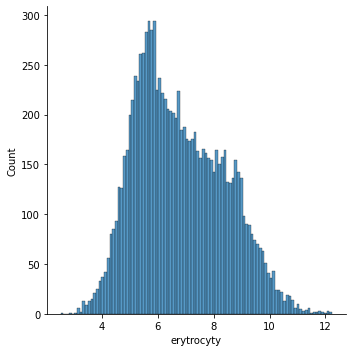

In [35]:
sns.displot(df['erytrocyty'],bins=100)

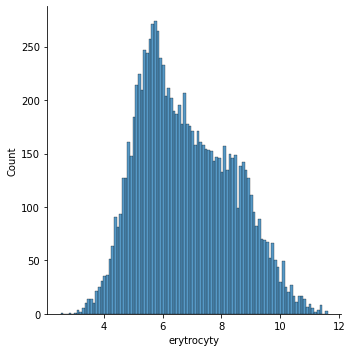

In [36]:
def identify_outliers(x):
    lower_ = x.quantile(0.25) - 1.5 * stats.iqr(x)
    upper_ = x.quantile(0.75) + 1.5 * stats.iqr(x)

    return x[(x > upper_) | (x < lower_)]

df_merged_out = identify_outliers(df["erytrocyty"])
df = df.drop(df_merged_out.index)
sns.displot(df['erytrocyty'],bins=100)

V atribute eryrocyty sme null hodnoty vyhodili a outlierov sme vyhodili takisto.

#### Atribut trombocyty

In [37]:
print(len((df[df['trombocyty'].isnull()])))

31


In [38]:
df['trombocyty'].fillna(df['trombocyty'].mean(), inplace=True)
print(len((df[df['trombocyty'].isnull()])))

0


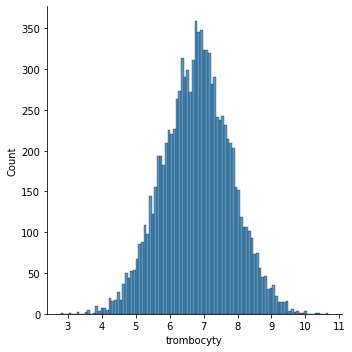

In [39]:
sns.displot(df['trombocyty'],bins=100)

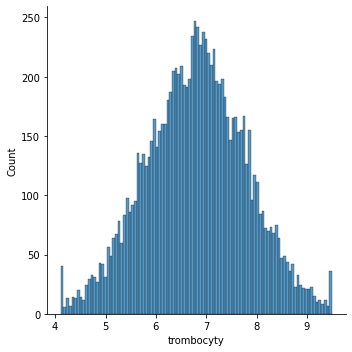

In [40]:
lower = df['trombocyty'].quantile(0.25) - 1.5 * stats.iqr(df['trombocyty'])
upper = df['trombocyty'].quantile(0.75) + 1.5 * stats.iqr(df['trombocyty'])

df["trombocyty"] = np.where(df["trombocyty"] > upper, upper, df['trombocyty'])
df["trombocyty"] = np.where(df["trombocyty"] < lower, lower, df['trombocyty'])
sns.displot(df['trombocyty'],bins=100)

V atribute trombocyty sme nahradili null hodnoty a outliers hranicnymi hodnotami rozdelenia

#### Atribut weight

In [41]:
df["weight"] = np.where(df["weight"] < 1, np.nan, df['weight'])
df.dropna(subset = ["weight"], inplace=True)
print(len((df[df['weight'].isnull()])))

0


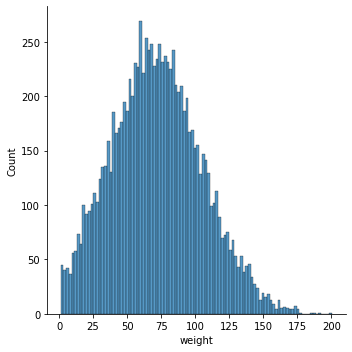

In [42]:
sns.displot(df['weight'],bins=100)

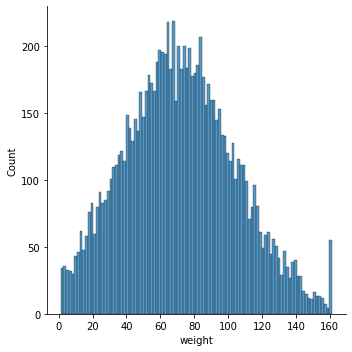

In [43]:
lower = df['weight'].quantile(0.25) - 1.5 * stats.iqr(df['weight'])
upper = df['weight'].quantile(0.75) + 1.5 * stats.iqr(df['weight'])

df["weight"] = np.where(df["weight"] > upper, upper, df['weight'])
df["weight"] = np.where(df["weight"] < lower, lower, df['weight'])
sns.displot(df['weight'],bins=100)

V atribute weight sme odstránili nezmyselné hodnoty (vahy menšie ako 1kg)
a nahradili sme za medián váh.

#### Atribut relation

In [44]:
print(len((df[df['relationship'].isnull()])))

0


In [45]:
df.dropna(subset = ["relationship"], inplace=True)
print(len((df[df['relationship'].isnull()])))

0


In [46]:
def sanitize_relation(relationship):
    if relationship == 'divoced' or relationship == 'divorced' :
        return 0
    elif relationship == 'single':
        return 1
    elif relationship == 'married':
        return 2
    elif relationship == 'widowed':
        return 3
    elif relationship == 'separated':
        return 4
    elif relationship == 'nop':
        return 5
    return relationship

In [47]:
df['relationship'] = df['relationship'].map(lambda relation: sanitize_relation(relation))

In [48]:
df['relationship'].unique()

array([0, 1, 2, 3, 4, 5], dtype=int64)

V atribute relationship sme vymazali null hodnoty a zvysne nahradili integer hodnotami (encoding)

#### Atribut smoker

In [49]:
print(len((df[df['smoker'].isnull()])))

0


In [50]:
df.dropna(subset = ["smoker"], inplace=True)
print(len((df[df['smoker'].isnull()])))

0


In [51]:
def sanitize_smoker(smoker):
    if smoker == 'N' or smoker == 'no' :
        return 0
    elif smoker == 'Y' or smoker == 'yes':
        return 1
    return smoker

In [52]:
df['smoker'] = df['smoker'].map(lambda smoker: sanitize_smoker(smoker))

In [53]:
df['smoker'].unique()

array([0, 1], dtype=int64)

V atribute smoker sme vymazali null hodnoty a zvysne nahradili integer hodnotami (encoding).

#### Atribut hbver

In [54]:
print(len((df[df['hbver'].isnull()])))

31


In [55]:
imputer = KNNImputer(n_neighbors=5)
df = pd.DataFrame(imputer.fit_transform(df), columns = df.columns)
print(len((df[df['hbver'].isnull()])))

0


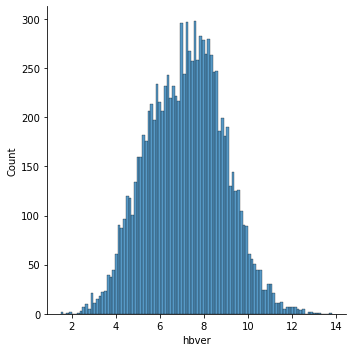

In [56]:
sns.displot(df['hbver'],bins=100)

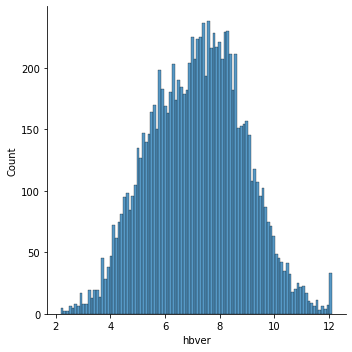

In [57]:
lower = df['hbver'].quantile(0.25) - 1.5 * stats.iqr(df['hbver'])
upper = df['hbver'].quantile(0.75) + 1.5 * stats.iqr(df['hbver'])

df["hbver"] = np.where(df["hbver"] > upper, upper, df['hbver'])
df["hbver"] = np.where(df["hbver"] < lower, lower, df['hbver'])
sns.displot(df['hbver'],bins=100)

V atribute hbver a v podstate celom datasete sme nahradili null hodnoty pomocou KNN algoritmu, cize dalej null hodnoty uz nebudeme riesit. A outlierov sme zase ustrihli a nahradili krajnymi hodnotami.

#### Atribut er-cv

In [58]:
print(len((df[df['er-cv'].isnull()])))

0


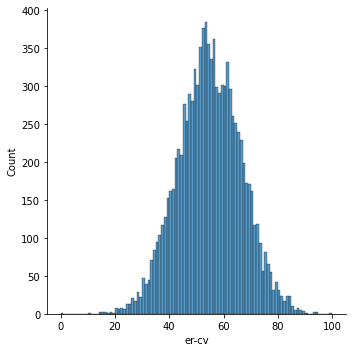

In [59]:
sns.displot(df['er-cv'],bins=100)

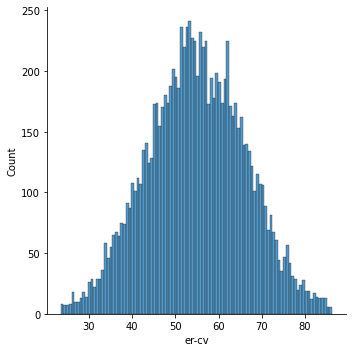

In [60]:
def identify_outliers(x):
    iqr = x.quantile(0.75) - x.quantile(0.25)
    lower_ = x.quantile(0.25) - 1.5 * iqr
    upper_ = x.quantile(0.75) + 1.5 * iqr

    return x[(x > upper_) | (x < lower_)]

df_merged_out = identify_outliers(df["er-cv"])
df = df.drop(df_merged_out.index)
sns.displot(df['er-cv'],bins=100)

V atribute er-cv sme uz teda nepotrebovali odstranovat null lebo knn. Outlierov sme odstranili pre zmenu.


#### Atribut hematokrit

In [61]:
print(len((df[df['hematokrit'].isnull()])))

0


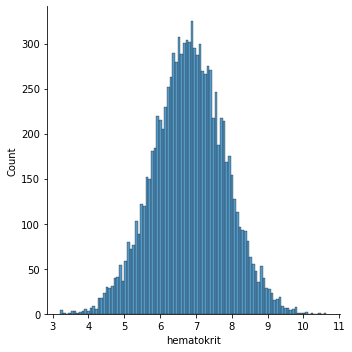

In [62]:
sns.displot(df['hematokrit'],bins=100)

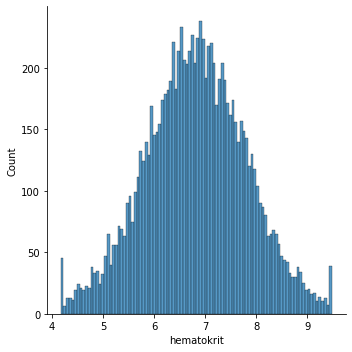

In [63]:
lower = df['hematokrit'].quantile(0.25) - 1.5 * stats.iqr(df['hematokrit'])
upper = df['hematokrit'].quantile(0.75) + 1.5 * stats.iqr(df['hematokrit'])

df["hematokrit"] = np.where(df["hematokrit"] > upper, upper, df['hematokrit'])
df["hematokrit"] = np.where(df["hematokrit"] < lower, lower, df['hematokrit'])
sns.displot(df['hematokrit'],bins=100)

V atribute hematokrit sme uz nepotrebovali odstranovat null lebo KNN. Outlierov sme nahradili krajnými hodnotami.

#### Atribut leukocyty

In [64]:
print(len((df[df['leukocyty'].isnull()])))

0


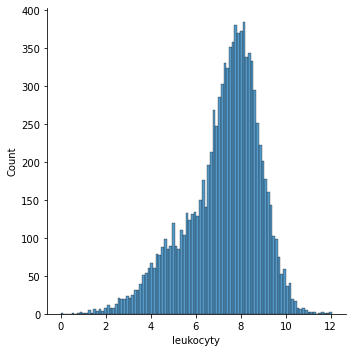

In [65]:
sns.displot(df['leukocyty'],bins=100)

In [66]:
def identify_outliers(x):
    iqr = x.quantile(0.75) - x.quantile(0.25)
    lower_ = x.quantile(0.25) - 1.5 * iqr
    upper_ = x.quantile(0.75) + 1.5 * iqr

    return x[(x > upper_) | (x < lower_)]

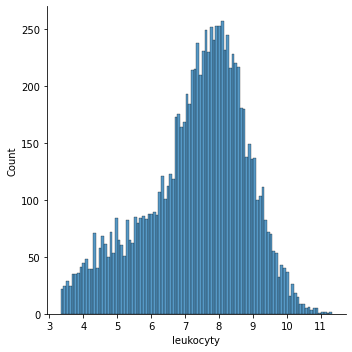

In [67]:
df_merged_out = identify_outliers(df["leukocyty"])
df = df.drop(df_merged_out.index)
sns.displot(df['leukocyty'],bins=100)

V atribute leukocyty sme uz teda nepotrebovali odstranovat null lebo knn. Outlierov sme odstranili pre zmenu.

#### Atribut alp

In [68]:
print(len((df[df['alp'].isnull()])))

0


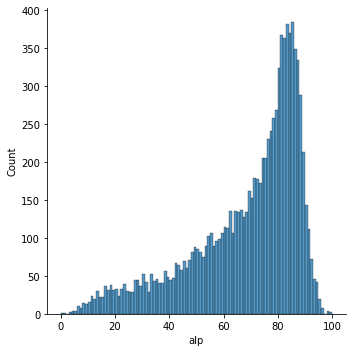

In [69]:
sns.displot(df['alp'],bins=100)

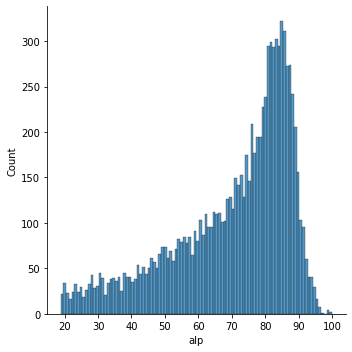

In [70]:
df_merged_out = identify_outliers(df["alp"])
df = df.drop(df_merged_out.index)
sns.displot(df['alp'],bins=100)

V atribute alp sme uz teda nepotrebovali odstranovat null lebo knn. Outlierov sme odstranili pre zmenu.


#### Atribut hemoglobin

In [71]:
print(len((df[df['hemoglobin'].isnull()])))

0


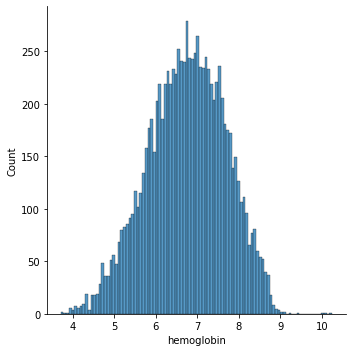

In [72]:
sns.displot(df['hemoglobin'],bins=100)

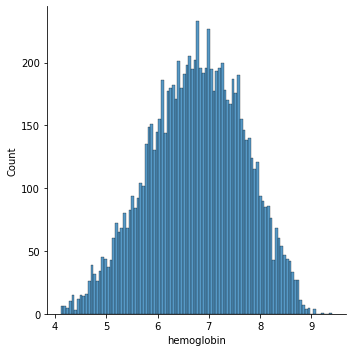

In [73]:
df_merged_out = identify_outliers(df["hemoglobin"])
df = df.drop(df_merged_out.index)
sns.displot(df['hemoglobin'],bins=100)

V atribute hemoglobin sme uz teda nepotrebovali odstranovat null lebo knn. Outlierov sme odstranili pre zmenu.

#### Atribut ast

In [74]:
print(len((df[df['ast'].isnull()])))

0


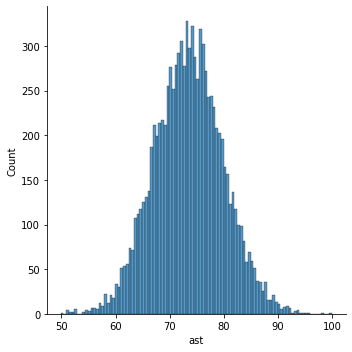

In [75]:
sns.displot(df['ast'],bins=100)

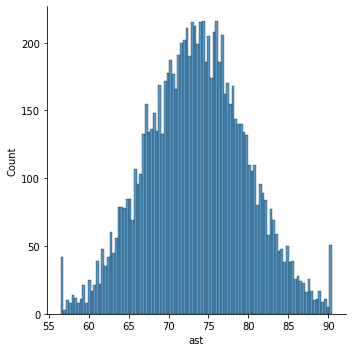

In [76]:
lower = df['ast'].quantile(0.25) - 1.5 * stats.iqr(df['ast'])
upper = df['ast'].quantile(0.75) + 1.5 * stats.iqr(df['ast'])

df["ast"] = np.where(df["ast"] > upper, upper, df['ast'])
df["ast"] = np.where(df["ast"] < lower, lower, df['ast'])
sns.displot(df['ast'],bins=100)

V atribute ast sme uz nepotrebovali odstranovat null lebo KNN. Outlierov sme nahradili krajnými hodnotami.

#### Atribut alt

In [77]:
print(len((df[df['alt'].isnull()])))

0


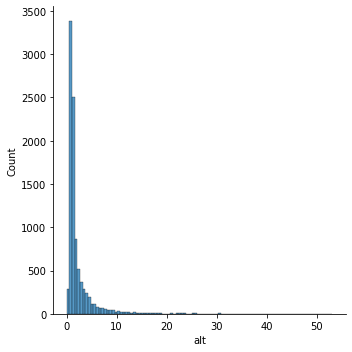

In [78]:
sns.displot(df['alt'],bins=100)

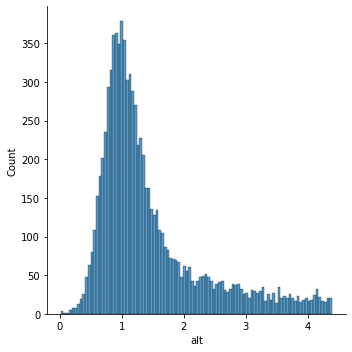

In [79]:
df_merged_out = identify_outliers(df["alt"])
df = df.drop(df_merged_out.index)
sns.displot(df['alt'],bins=100)

V atribute alt sme uz teda nepotrebovali odstranovat null lebo knn. Outlierov sme odstranili pre zmenu.

#### Atribut etytr

In [80]:
print(len((df[df['etytr'].isnull()])))

0


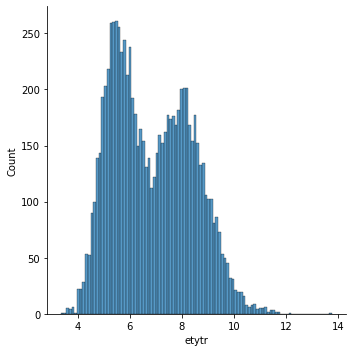

In [81]:
sns.displot(df['etytr'],bins=100)

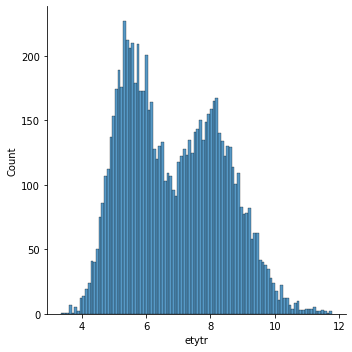

In [82]:
df_merged_out = identify_outliers(df["etytr"])
df = df.drop(df_merged_out.index)
sns.displot(df['etytr'],bins=100)

V atribute etytr sme uz teda nepotrebovali odstranovat null lebo knn. Outlierov sme odstranili pre zmenu.

#### Atribut ast

In [83]:
print(len((df[df['age'].isnull()])))

0


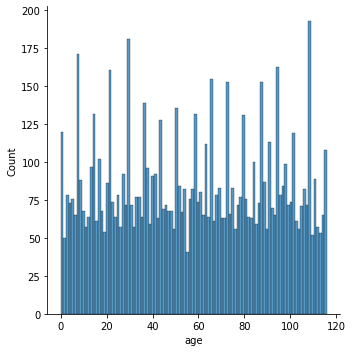

In [84]:
sns.displot(df['age'],bins=100)

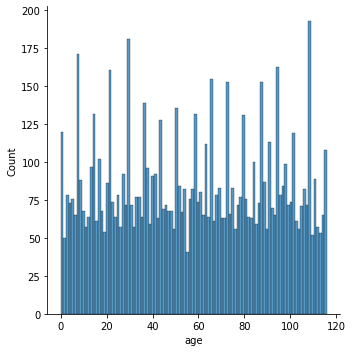

In [85]:
lower = df['age'].quantile(0.25) - 1.5 * stats.iqr(df['age'])
upper = df['age'].quantile(0.75) + 1.5 * stats.iqr(df['age'])

df["age"] = np.where(df["age"] > upper, upper, df['age'])
df["age"] = np.where(df["age"] < lower, lower, df['age'])
sns.displot(df['age'],bins=100)

V atribute age sme uz nepotrebovali odstranovat null lebo KNN. Outlierov sme nahradili krajnými hodnotami.

### 2. Realizácia predspracovania dát (5b)

Rozhodli sme sa rozdeliť dataset na 15% pre testovacie dáta a 85% na trénovacie dáta. Ďalej sa bude teda spracovávať len trénovacia vzorka.

In [86]:
df_train, df_test = train_test_split(df, test_size=0.15)


In [87]:
len(df_train)

7225

In [88]:
len(df_test)

1275

C:\Users\matej\AppData\Local\Temp/ipykernel_14108/1701832074.py:3: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  df_train.hist(ax = ax)


array([[<AxesSubplot:title={'center':'sex'}>,
        <AxesSubplot:title={'center':'blood_group'}>,
        <AxesSubplot:title={'center':'race'}>,
        <AxesSubplot:title={'center':'erytrocyty'}>],
       [<AxesSubplot:title={'center':'trombocyty'}>,
        <AxesSubplot:title={'center':'weight'}>,
        <AxesSubplot:title={'center':'hbver'}>,
        <AxesSubplot:title={'center':'relationship'}>],
       [<AxesSubplot:title={'center':'er-cv'}>,
        <AxesSubplot:title={'center':'smoker'}>,
        <AxesSubplot:title={'center':'indicator'}>,
        <AxesSubplot:title={'center':'hematokrit'}>],
       [<AxesSubplot:title={'center':'leukocyty'}>,
        <AxesSubplot:title={'center':'alp'}>,
        <AxesSubplot:title={'center':'hemoglobin'}>,
        <AxesSubplot:title={'center':'ast'}>],
       [<AxesSubplot:title={'center':'alt'}>,
        <AxesSubplot:title={'center':'etytr'}>,
        <AxesSubplot:title={'center':'age'}>, <AxesSubplot:>]],
      dtype=object)

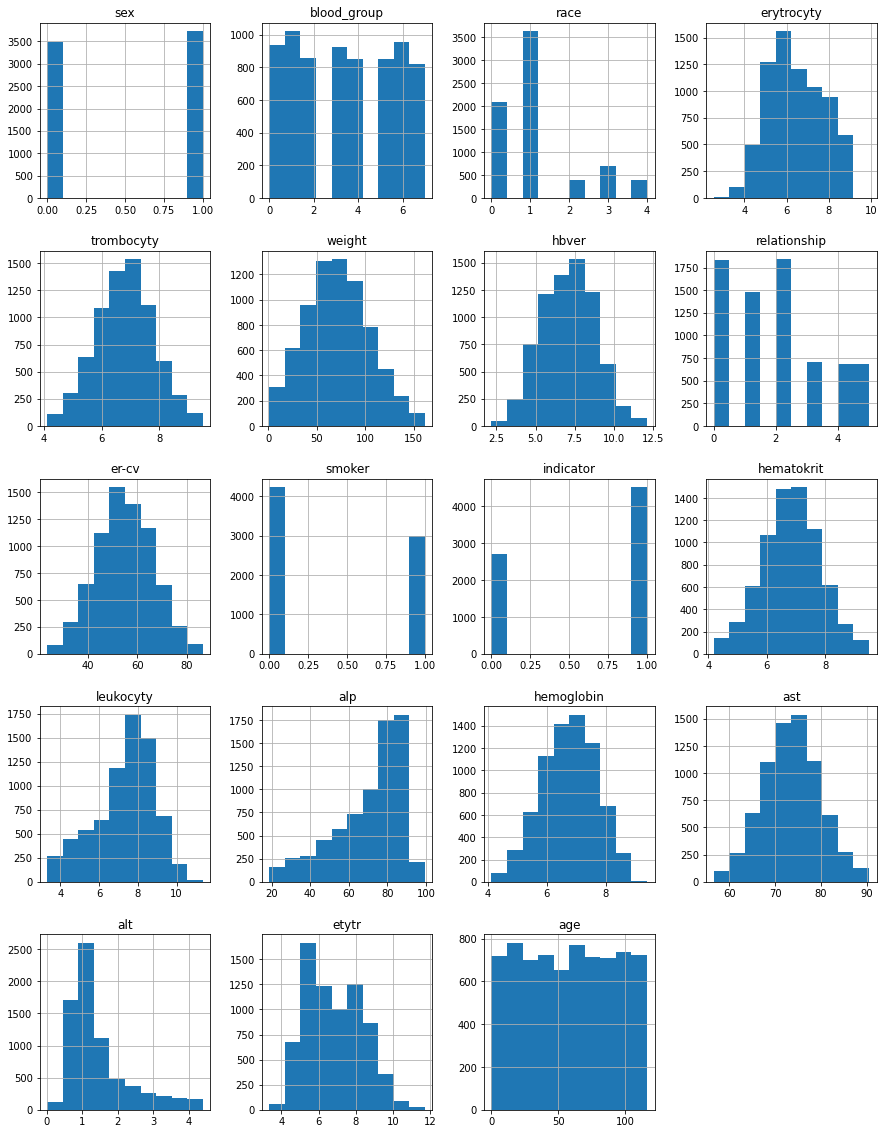

In [89]:
fig = plt.figure(figsize = (15,20))
ax = fig.gca()
df_train.hist(ax = ax)


In [90]:
columns = ['erytrocyty', 'trombocyty', 'weight', 'hbver', 'er-cv', 'hematokrit', 'leukocyty', 'alp', 'hemoglobin', 'ast', 'alt', 'etytr', 'age']
features = df_train[columns]

In [91]:
scaler = MinMaxScaler()
df_train[columns] = scaler.fit_transform(df_train[columns])

C:\Users\matej\AppData\Local\Temp/ipykernel_14108/1193389048.py:3: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  df_train.hist(ax = ax)


array([[<AxesSubplot:title={'center':'sex'}>,
        <AxesSubplot:title={'center':'blood_group'}>,
        <AxesSubplot:title={'center':'race'}>,
        <AxesSubplot:title={'center':'erytrocyty'}>],
       [<AxesSubplot:title={'center':'trombocyty'}>,
        <AxesSubplot:title={'center':'weight'}>,
        <AxesSubplot:title={'center':'hbver'}>,
        <AxesSubplot:title={'center':'relationship'}>],
       [<AxesSubplot:title={'center':'er-cv'}>,
        <AxesSubplot:title={'center':'smoker'}>,
        <AxesSubplot:title={'center':'indicator'}>,
        <AxesSubplot:title={'center':'hematokrit'}>],
       [<AxesSubplot:title={'center':'leukocyty'}>,
        <AxesSubplot:title={'center':'alp'}>,
        <AxesSubplot:title={'center':'hemoglobin'}>,
        <AxesSubplot:title={'center':'ast'}>],
       [<AxesSubplot:title={'center':'alt'}>,
        <AxesSubplot:title={'center':'etytr'}>,
        <AxesSubplot:title={'center':'age'}>, <AxesSubplot:>]],
      dtype=object)

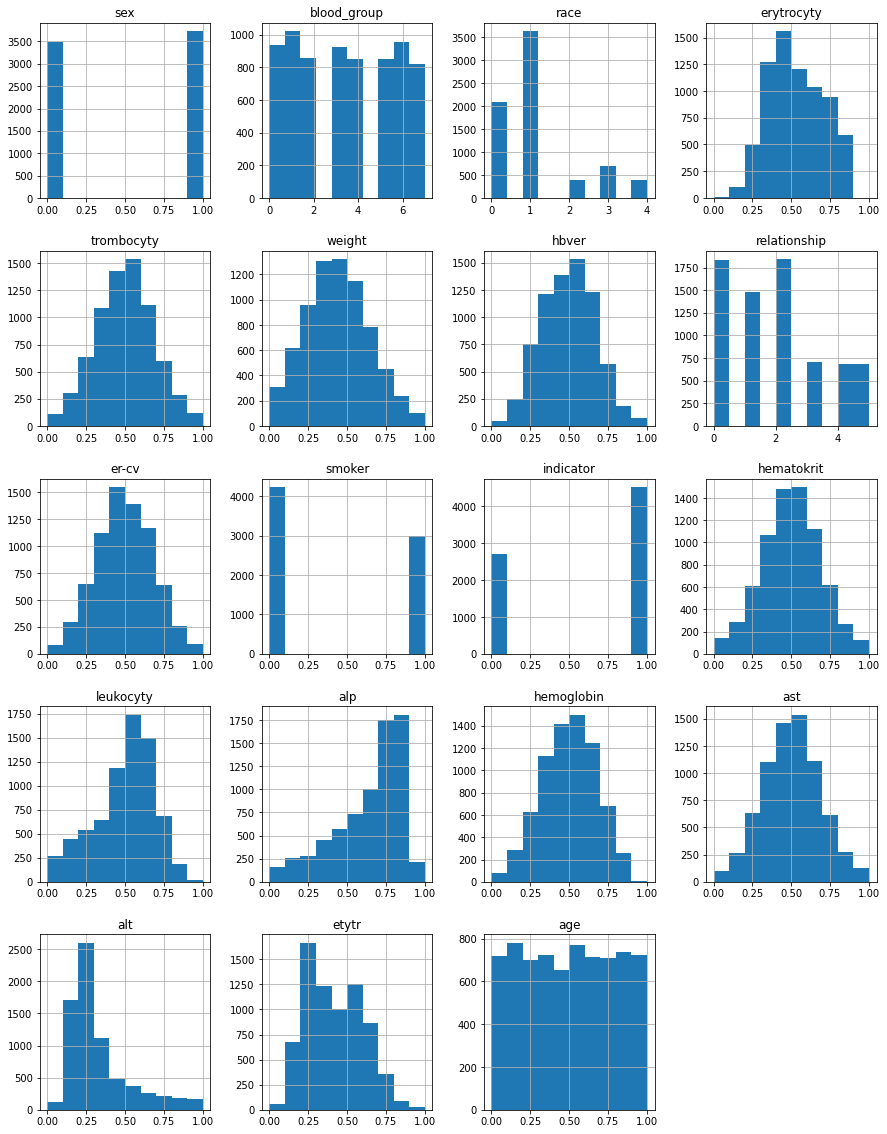

In [92]:
fig = plt.figure(figsize = (15,20))
ax = fig.gca()
df_train.hist(ax = ax)

In [93]:
transformer = PowerTransformer(method = 'yeo-johnson')
df_train[columns] = transformer.fit_transform(features.values)

C:\Users\matej\AppData\Local\Temp/ipykernel_14108/1193389048.py:3: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  df_train.hist(ax = ax)


array([[<AxesSubplot:title={'center':'sex'}>,
        <AxesSubplot:title={'center':'blood_group'}>,
        <AxesSubplot:title={'center':'race'}>,
        <AxesSubplot:title={'center':'erytrocyty'}>],
       [<AxesSubplot:title={'center':'trombocyty'}>,
        <AxesSubplot:title={'center':'weight'}>,
        <AxesSubplot:title={'center':'hbver'}>,
        <AxesSubplot:title={'center':'relationship'}>],
       [<AxesSubplot:title={'center':'er-cv'}>,
        <AxesSubplot:title={'center':'smoker'}>,
        <AxesSubplot:title={'center':'indicator'}>,
        <AxesSubplot:title={'center':'hematokrit'}>],
       [<AxesSubplot:title={'center':'leukocyty'}>,
        <AxesSubplot:title={'center':'alp'}>,
        <AxesSubplot:title={'center':'hemoglobin'}>,
        <AxesSubplot:title={'center':'ast'}>],
       [<AxesSubplot:title={'center':'alt'}>,
        <AxesSubplot:title={'center':'etytr'}>,
        <AxesSubplot:title={'center':'age'}>, <AxesSubplot:>]],
      dtype=object)

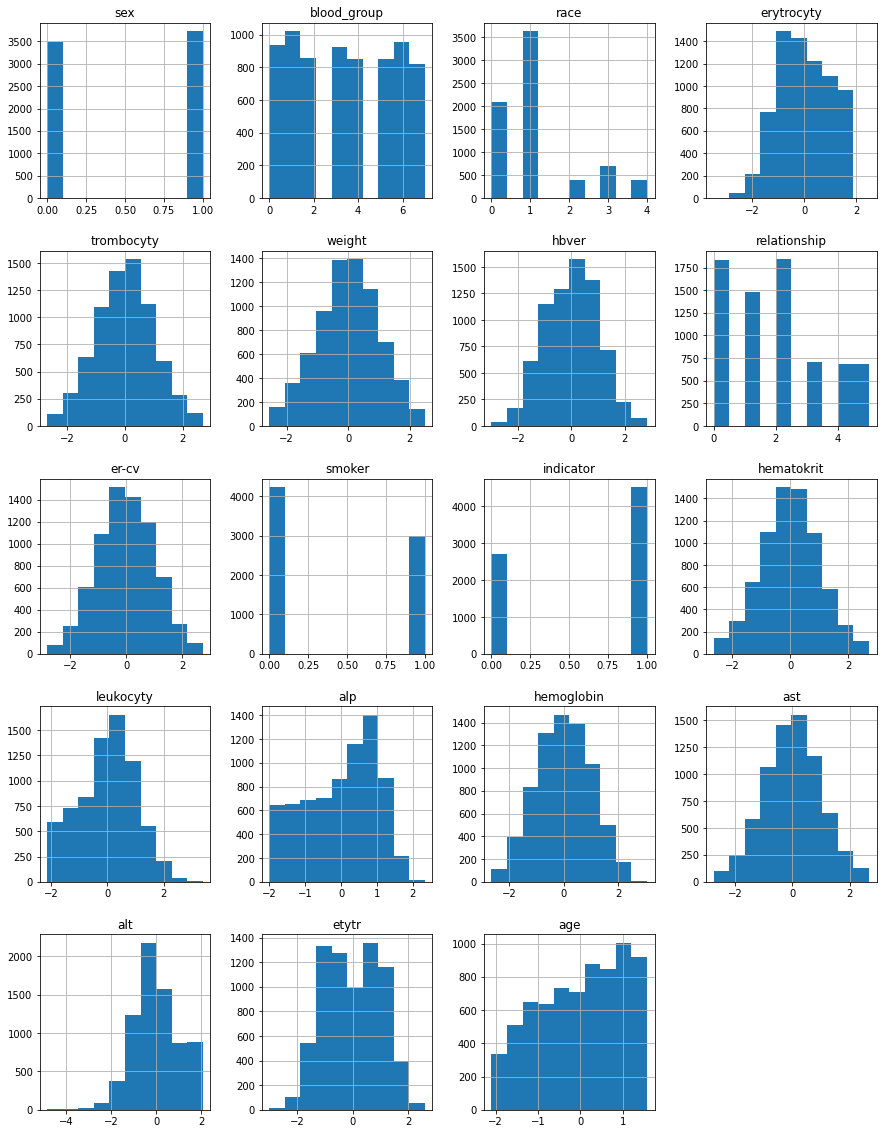

In [94]:
fig = plt.figure(figsize = (15,20))
ax = fig.gca()
df_train.hist(ax = ax)

## 3. Výber atribútov pre strojové učenie (5b)

Trenovaci dataset sme si rozdelili na kategoricke a numericke hodnoty. Na každú skupinu použijeme iný výber features.

In [95]:
feature_cols = ['sex', 'blood_group', 'race', 'relationship', 'smoker', 'erytrocyty', 'trombocyty', 'weight', 'hbver', 'er-cv', 'hematokrit', 'leukocyty', 'alp', 'hemoglobin', 'ast', 'alt', 'etytr', 'age']
output_cols = ['indicator']

In [96]:
def split_dataset(dataset):
    global feature_cols
    global output_cols
    
    X = dataset[feature_cols].values
    y = dataset[output_cols].values
    return X, y

In [97]:
X_train, y_train = split_dataset(df_train)
X_test, y_test = split_dataset(df_test)

C:\Users\matej\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Feature hbver: 983.910069
Feature leukocyty: 762.156494
Feature etytr: 120.954794
Feature smoker: 7.379779
Feature erytrocyty: 2.606462
Feature hematokrit: 2.450209
Feature er-cv: 2.038474
Feature blood_group: 1.600725
Feature age: 0.949399
Feature sex: 0.733022
Feature race: 0.536023
Feature hemoglobin: 0.243464
Feature alt: 0.208030
Feature alp: 0.176648
Feature trombocyty: 0.148217
Feature relationship: 0.033485
Feature ast: 0.012137
Feature weight: 0.010449


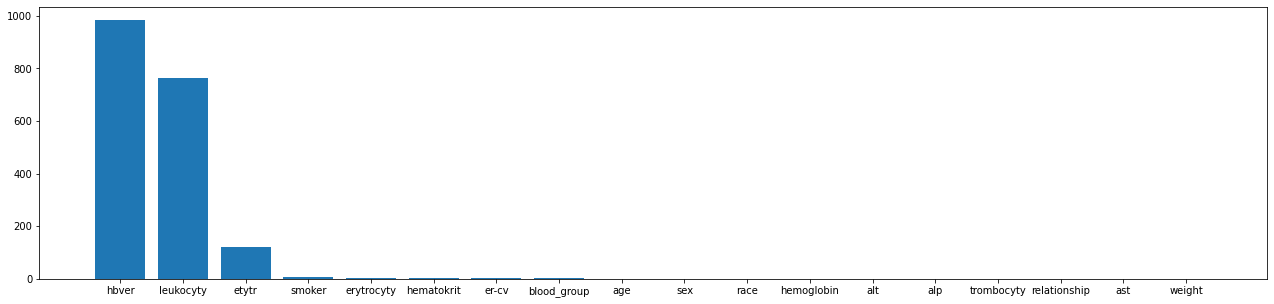

In [98]:
def select_features(X_train, y_train, X_test):
    fs = SelectKBest(score_func=f_classif, k='all')
    fs.fit(X_train, y_train)
    X_train_fs = fs.transform(X_train)
    X_test_fs = fs.transform(X_test)
    return X_train_fs, X_test_fs, fs
 
X_train_fs, X_test_fs, fs = select_features(X_train, y_train, X_test)

dictX = {}
for i in range(len(fs.scores_)):
    dictX[i] = fs.scores_[i]
    
dictX = dict(sorted(dictX.items(), key=lambda item: item[1], reverse=True))

for i in dictX:
    print('Feature %s: %f' % (feature_cols[i], dictX[i]))

plt.subplots(figsize=(22,5))
plt.bar([feature_cols[x] for x in dictX.keys()], dictX.values())
plt.show()

ANOVA

## 4. Replikovateľnosť predspracovania (5b)

In [99]:
df = load_datasets("001/profiles.csv","001/labor.csv")
df = fix_dataset(df)

In [100]:
feature_cols = ['sex', 'blood_group', 'race', 'relationship', 'smoker', 'erytrocyty', 'trombocyty', 'weight', 'hbver', 'er-cv', 'hematokrit', 'leukocyty', 'alp', 'hemoglobin', 'ast', 'alt', 'etytr', 'age']
output_cols = ['indicator']
categorical_cols = ['sex', 'blood_group', 'race', 'relationship', 'smoker']
numerical_cols = ['erytrocyty', 'trombocyty', 'weight', 'hbver', 'er-cv', 'hematokrit', 'leukocyty', 'alp', 'hemoglobin', 'ast', 'alt', 'etytr', 'age']

In [101]:
class CustomEncoderTransformer(TransformerMixin):
    def __init__(self, column_names= []):
        self.column_names = column_names
        
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        global categorical_cols
        X = pd.DataFrame(X, columns=self.column_names)
        enc = OrdinalEncoder()
        X[categorical_cols] = enc.fit_transform(X[categorical_cols])
        return X

In [102]:
class CustomOutlierTransformer(TransformerMixin):
    def __init__(self, column_names= [], strategy="drop"):
        self.column_names = column_names
        self.strategy = strategy;
        
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = pd.DataFrame(X, columns=self.column_names)
        for column in X.columns:
            df_merged_out = identify_outliers(X[column])
            if (self.strategy == "drop"):
                X = X.drop(df_merged_out.index)
            elif (self.strategy == "mean"):
                X[column].fillna(X[column].mean(), inplace=True)

        return X
    
    def identify_outliers(x):
        iqr = x.quantile(0.75) - x.quantile(0.25)
        lower_ = x.quantile(0.25) - 1.5 * iqr
        upper_ = x.quantile(0.75) + 1.5 * iqr

        return x[(x > upper_) | (x < lower_)]

In [103]:
class CustomMinMaxTransformer(TransformerMixin):
    def __init__(self, column_names= []):
        self.column_names = column_names
        
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        global numerical_cols
        X = pd.DataFrame(X, columns=self.column_names)
        scaler = MinMaxScaler()
        X[numerical_cols] = scaler.fit_transform(X[numerical_cols])
        return X

In [104]:
class CustomKnnForNullValuesTransformer(TransformerMixin):
    def __init__(self, column_names= []):
        self.column_names = column_names
        
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = pd.DataFrame(X, columns=self.column_names)
        imputer = KNNImputer(n_neighbors=5)
        X = pd.DataFrame(imputer.fit_transform(X), columns = X.columns)
        return X

In [105]:

class DfToValuesOnlyTransformer(TransformerMixin):
    def __init__(self, column_names= []):
        self.column_names = column_names
        
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = pd.DataFrame(X, columns=self.column_names)
        X, y = split_dataset(X)
        return X, y
    
    def split_dataset(dataset):
        global feature_cols
        global output_cols

        X = dataset[feature_cols].values
        y = dataset[output_cols].values
        return X, y

In [108]:
encoder = CustomEncoderTransformer(df.columns)
outlier = CustomOutlierTransformer(df.columns)
minmax = CustomMinMaxTransformer(df.columns)
nulls = CustomKnnForNullValuesTransformer(df.columns)
split = DfToValuesOnlyTransformer(df.columns)

my_pipeline = make_pipeline(encoder, nulls, outlier, minmax, split)
X, y = my_pipeline.fit_transform(df)

my_pipeline = make_pipeline(encoder, nulls, outlier, minmax)
df_out = my_pipeline.fit_transform(df)
df_out.to_csv('merged_dataset.csv')

In [107]:
def evaluate_model(model, X, y):
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
    return scores
 

num_features = [i+1 for i in range(X.shape[1])]
results = list()
for k in num_features:

    model = LogisticRegression(solver='liblinear')
    fs = SelectKBest(score_func=f_classif, k=k)

    pipeline = Pipeline(steps=[('anova',fs), ('liblinear', model)])

    scores = evaluate_model(pipeline, X, y)
    results.append(scores)

    print('Počet vybraných atribútov: %d, Accuracy score: %.3f ' % (k, mean(scores)))
    


Počet vybraných atribútov: 1, Accuracy score: 0.648 
Počet vybraných atribútov: 2, Accuracy score: 0.795 
Počet vybraných atribútov: 3, Accuracy score: 0.792 
Počet vybraných atribútov: 4, Accuracy score: 0.791 
Počet vybraných atribútov: 5, Accuracy score: 0.790 
Počet vybraných atribútov: 6, Accuracy score: 0.791 
Počet vybraných atribútov: 7, Accuracy score: 0.791 
Počet vybraných atribútov: 8, Accuracy score: 0.791 
Počet vybraných atribútov: 9, Accuracy score: 0.792 
Počet vybraných atribútov: 10, Accuracy score: 0.791 
Počet vybraných atribútov: 11, Accuracy score: 0.792 
Počet vybraných atribútov: 12, Accuracy score: 0.792 
Počet vybraných atribútov: 13, Accuracy score: 0.791 
Počet vybraných atribútov: 14, Accuracy score: 0.791 
Počet vybraných atribútov: 15, Accuracy score: 0.791 
Počet vybraných atribútov: 16, Accuracy score: 0.791 
Počet vybraných atribútov: 17, Accuracy score: 0.791 
Počet vybraných atribútov: 18, Accuracy score: 0.791 
